In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem, DataStructs
from rdkit.Chem import QED, Descriptors, AllChem

In [2]:
def load_results_tsv(path):
    df = pd.read_csv(path, sep="\t")
    return df

In [3]:
def validate_smiles(smiles_list):
    valid_smiles = []
    invalid_indices = []
    for i, smi in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            invalid_indices.append(i)
        else:
            valid_smiles.append(smi)
    return valid_smiles, invalid_indices

In [4]:
def compute_metrics(smiles_list):
    qeds, logps = [], []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            qeds.append(QED.qed(mol))
            logps.append(Descriptors.MolLogP(mol))
    return np.array(qeds), np.array(logps)

In [5]:
def compute_diversity(smiles_list):
    fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), 2) for smi in smiles_list]
    n = len(fps)
    if n < 2:
        return 0.0, 0.0
    sims = []
    for i in range(n):
        for j in range(i+1, n):
            sim = DataStructs.TanimotoSimilarity(fps[i], fps[j])
            sims.append(sim)
    return np.mean(sims), np.std(sims)

In [6]:
def plot_distributions(qeds, logps, label=""):
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    sns.histplot(qeds, bins=20, kde=True, color='green')
    plt.title(f"QED Distribution {label}")
    
    plt.subplot(1, 2, 2)
    sns.histplot(logps, bins=20, kde=True, color='red')
    plt.title(f"LogP Distribution {label}")
    
    plt.tight_layout()
    plt.show()

In [7]:
def summarize_results(df):
    smiles = df['SMILES'].tolist()
    rewards = df['Reward'].values
    
    valid_smiles, invalid_idx = validate_smiles(smiles)
    unique_smiles = set(valid_smiles)
    
    mean_reward = np.mean(rewards)
    max_reward = np.max(rewards)
    validity_pct = 100 * len(valid_smiles) / len(smiles)
    uniqueness_pct = 100 * len(unique_smiles) / len(valid_smiles) if valid_smiles else 0
    
    qeds_valid, logp_valid = compute_metrics(valid_smiles)
    diversity_mean, diversity_std = compute_diversity(valid_smiles)
    
    print("=== Optimization Results Summary ===")
    print(f"Total molecules:           {len(smiles)}")
    print(f"Valid molecules:           {len(valid_smiles)} ({validity_pct:.1f}%)")
    print(f"Unique molecules:          {len(unique_smiles)} ({uniqueness_pct:.1f}%)")
    print(f"Mean Reward:               {mean_reward:.4f}")
    print(f"Max Reward:                {max_reward:.4f}")
    print(f"Mean QED (valid):          {np.mean(qeds_valid):.4f}")
    print(f"Mean LogP (valid):         {np.mean(logp_valid):.4f}")
    print(f"Diversity (mean Tanimoto): {diversity_mean:.4f} ± {diversity_std:.4f}")
    print(f"Invalid SMILES count:      {len(invalid_idx)}")
    
    plot_distributions(qeds_valid, logp_valid, label="(Valid Molecules)")

In [8]:
def validate_single_epoch(epoch, results_dir="latent_logs"):
    results_path = os.path.join(results_dir, f"results_iter_{epoch}.tsv")
    if not os.path.exists(results_path):
        print(f"Results file for epoch {epoch} not found at {results_path}")
        return
    print(f"Validating epoch {epoch} from: {results_path}")
    df = load_results_tsv(results_path)
    summarize_results(df)
    return df

In [9]:
def get_epoch_metrics(df):
    smiles = df['SMILES'].tolist()
    rewards = df['Reward'].values
    valid_smiles, _ = validate_smiles(smiles)
    unique_smiles = set(valid_smiles)
    
    mean_reward = np.mean(rewards)
    max_reward = np.max(rewards)
    validity_pct = 100 * len(valid_smiles) / len(smiles)
    uniqueness_pct = 100 * len(unique_smiles) / len(valid_smiles) if valid_smiles else 0
    
    return mean_reward, max_reward, validity_pct, uniqueness_pct


In [10]:
def plot_metrics_over_epochs(start_epoch, end_epoch, results_dir="latent_logs"):
    epochs = list(range(start_epoch, end_epoch + 1))
    mean_rewards, max_rewards, validities, uniquenesses, sas_scores, diversity_scores = [], [], [], [], [], []

    for epoch in epochs:
        path = os.path.join(results_dir, f"results_iter_{epoch}.tsv")
        if not os.path.exists(path):
            print(f"Warning: No results file for epoch {epoch} at {path}")
            continue
        df = load_results_tsv(path)
        mean_r, max_r, val_pct, uniq_pct = get_epoch_metrics(df)
        
        # Compute SAS and diversity for this epoch
        valid_smiles = [smi for smi in df['SMILES'] if Chem.MolFromSmiles(smi)]
        sas_list = []
        for smi in valid_smiles:
            mol = Chem.MolFromSmiles(smi)
            if mol:
                sas_list.append(compute_sas(mol))
        
        diversity_mean, _ = compute_diversity(valid_smiles)
        
        mean_rewards.append(mean_r)
        max_rewards.append(max_r)
        validities.append(val_pct)
        uniquenesses.append(uniq_pct)
        sas_scores.append(np.mean(sas_list) if sas_list else 0)
        diversity_scores.append(diversity_mean)

    # Adjust epochs list for missing files
    valid_epochs = epochs[:len(mean_rewards)]

    plt.figure(figsize=(18, 12))

    plt.subplot(2, 3, 1)
    plt.plot(valid_epochs, mean_rewards, marker='o')
    plt.title("Mean Reward Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Reward")

    plt.subplot(2, 3, 2)
    plt.plot(valid_epochs, max_rewards, marker='o', color='green')
    plt.title("Max Reward Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Max Reward")

    plt.subplot(2, 3, 3)
    plt.plot(valid_epochs, validities, marker='o', color='orange')
    plt.title("Validity (%) Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Validity (%)")

    plt.subplot(2, 3, 4)
    plt.plot(valid_epochs, uniquenesses, marker='o', color='red')
    plt.title("Uniqueness (%) Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Uniqueness (%)")
    
    plt.subplot(2, 3, 5)
    plt.plot(valid_epochs, sas_scores, marker='o', color='purple')
    plt.title("SAS Score Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("SAS Score")
    
    plt.subplot(2, 3, 6)
    plt.plot(valid_epochs, diversity_scores, marker='o', color='teal')
    plt.title("Diversity Score Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Diversity (1 - Tanimoto)")

    plt.tight_layout()
    plt.show()

In [11]:
def print_progress_deltas(start_epoch, end_epoch, results_dir="latent_logs"):
    epochs = list(range(start_epoch, end_epoch + 1))
    metrics = []

    for epoch in epochs:
        path = os.path.join(results_dir, f"results_iter_{epoch}.tsv")
        if not os.path.exists(path):
            print(f"Warning: No results file for epoch {epoch} at {path}")
            continue
        df = load_results_tsv(path)
        mean_r, max_r, val_pct, uniq_pct = get_epoch_metrics(df)
        metrics.append({
            "epoch": epoch,
            "mean_reward": mean_r,
            "max_reward": max_r,
            "validity": val_pct,
            "uniqueness": uniq_pct,
        })

    print("Progress per Epoch (Delta from previous epoch):")
    print("Epoch | Mean Reward Δ | Max Reward Δ | Validity Δ (%) | Uniqueness Δ (%)")
    print("----------------------------------------------------------------------")

    for i in range(1, len(metrics)):
        delta_mean = metrics[i]["mean_reward"] - metrics[i-1]["mean_reward"]
        delta_max = metrics[i]["max_reward"] - metrics[i-1]["max_reward"]
        delta_val = metrics[i]["validity"] - metrics[i-1]["validity"]
        delta_uniq = metrics[i]["uniqueness"] - metrics[i-1]["uniqueness"]

        print(f"{metrics[i]['epoch']:5d} | {delta_mean:13.4f} | {delta_max:12.4f} | {delta_val:14.2f} | {delta_uniq:16.2f}")

Validating epoch 10 from: latent_logs/results_iter_10.tsv
=== Optimization Results Summary ===
Total molecules:           47
Valid molecules:           47 (100.0%)
Unique molecules:          38 (80.9%)
Mean Reward:               3.1999
Max Reward:                4.1122
Mean QED (valid):          0.6529
Mean LogP (valid):         3.3267
Diversity (mean Tanimoto): 0.1907 ± 0.1883
Invalid SMILES count:      0


[19:15:51] DEPRECATION WARNING: please use MorganGenerator
[19:15:51] DEPRECATION WARNING: please use MorganGenerator
[19:15:51] DEPRECATION WARNING: please use MorganGenerator
[19:15:51] DEPRECATION WARNING: please use MorganGenerator
[19:15:51] DEPRECATION WARNING: please use MorganGenerator
[19:15:51] DEPRECATION WARNING: please use MorganGenerator
[19:15:51] DEPRECATION WARNING: please use MorganGenerator
[19:15:51] DEPRECATION WARNING: please use MorganGenerator
[19:15:51] DEPRECATION WARNING: please use MorganGenerator
[19:15:51] DEPRECATION WARNING: please use MorganGenerator
[19:15:51] DEPRECATION WARNING: please use MorganGenerator
[19:15:51] DEPRECATION WARNING: please use MorganGenerator
[19:15:51] DEPRECATION WARNING: please use MorganGenerator
[19:15:51] DEPRECATION WARNING: please use MorganGenerator
[19:15:51] DEPRECATION WARNING: please use MorganGenerator
[19:15:51] DEPRECATION WARNING: please use MorganGenerator
[19:15:51] DEPRECATION WARNING: please use MorganGenerat

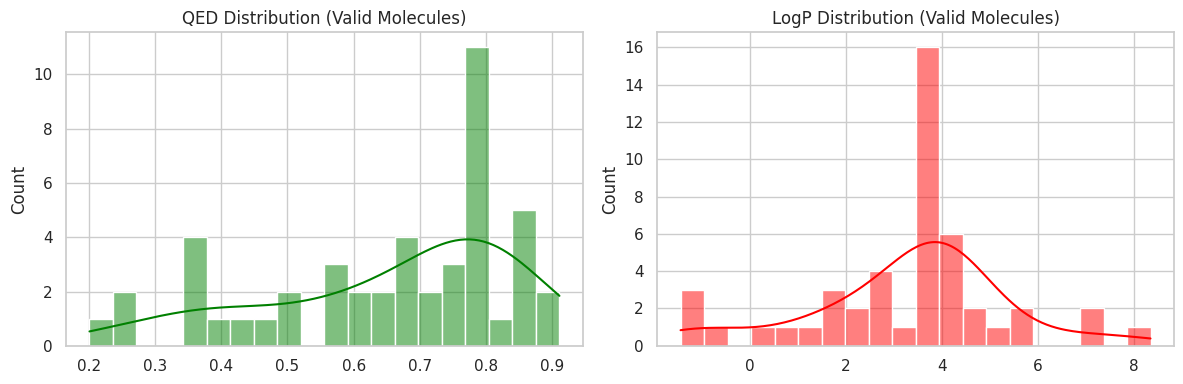

Progress per Epoch (Delta from previous epoch):
Epoch | Mean Reward Δ | Max Reward Δ | Validity Δ (%) | Uniqueness Δ (%)
----------------------------------------------------------------------
    2 |       -0.5626 |       0.4670 |           0.00 |             2.00
    3 |        0.6893 |       0.2645 |           0.00 |            14.00
    4 |        0.8051 |       0.1332 |           0.00 |             6.00
    5 |       -0.0666 |      -0.0268 |           0.00 |             0.00
    6 |        0.1844 |       0.1086 |           0.00 |            -6.00
    7 |        0.0424 |       0.2394 |           0.00 |             8.00
    8 |        0.0009 |      -0.3009 |           0.00 |             0.00
    9 |        0.1523 |      -0.0966 |           0.00 |             0.00
   10 |       -0.0366 |       0.5544 |           0.00 |            46.85
   11 |        0.0621 |      -0.0683 |           0.00 |             5.20
   12 |        0.2145 |       0.1184 |           0.00 |            11.25
   13

In [12]:
epoch_to_validate = 10
validate_single_epoch(epoch_to_validate, results_dir="latent_logs")

print_progress_deltas(start_epoch=1, end_epoch=42, results_dir="latent_logs")

[19:19:07] DEPRECATION WARNING: please use MorganGenerator


=== Optimization Results Summary ===
Total molecules:           1
Valid molecules:           1 (100.0%)
Unique molecules:          1 (100.0%)
Mean Reward:               -8.0238
Max Reward:                -8.0238
Mean QED (valid):          0.0533
Mean LogP (valid):         78.2660
Diversity (mean Tanimoto): 0.0000 ± 0.0000
Invalid SMILES count:      0


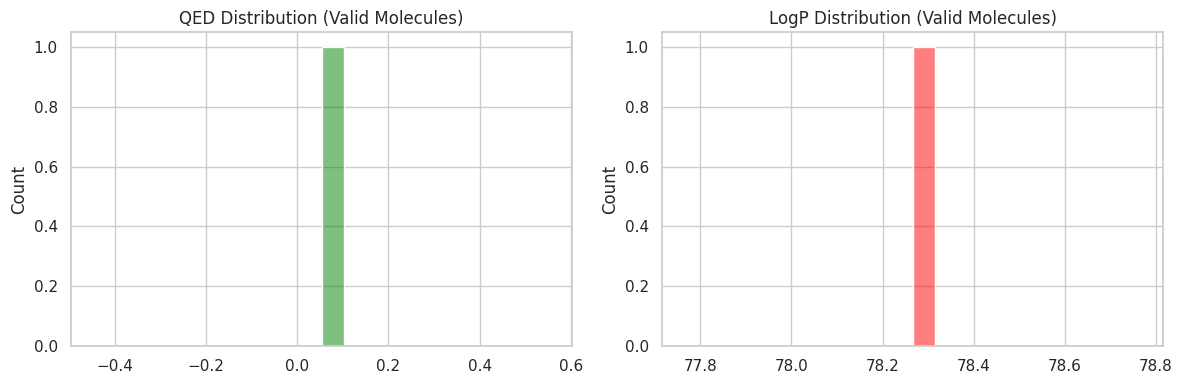

In [15]:

results_file = "latent_logs/results_iter_41.tsv"  # Change this path as needed
results_df = load_results_tsv(results_file)
summarize_results(results_df)